In [54]:
import os

# Force CPU usage
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['NO_MPS'] = '1'

import random
from faker import Faker
import numpy as np
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers import SentenceTransformer, InputExample, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from torch.utils.data import DataLoader

# Ensure CPU device
if torch.cuda.is_available():
    torch.cuda.is_available = lambda: False

if torch.backends.mps.is_available():
    torch.backends.mps.is_available = lambda: False

device = torch.device('cpu')


In [55]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


In [56]:
# Initialize Faker
fake = Faker()

def generate_business_names(n=5000):
    industries = ['Tech', 'Finance', 'Healthcare', 'Retail', 'Manufacturing']
    suffixes = ['Inc', 'LLC', 'Corp', 'Co', '']
    
    base_names = []
    for _ in range(n):
        industry = random.choice(industries)
        name = f"{fake.company()} {random.choice(suffixes)}"
        base_names.append((name, industry))
    
    variations = []
    for name, industry in base_names:
        variations.extend([
            (name, f"{name} {industry}", True),
            (name, ' '.join(reversed(name.split())), True),
            (name, name.replace('Inc', 'Incorporated'), True),
            (name, f"{name[:len(name)//2]}", True),
            (name, f"{fake.company()} {industry}", False),
            (name, f"{name.split()[0]} {fake.company().split()[-1]}", False)
        ])
    
    return variations

# Generate dataset
dataset = generate_business_names()
# Split dataset
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)


In [57]:
def evaluate_model(model, test_data):
    names1, names2, labels = zip(*test_data)
    with torch.no_grad():
        embeddings1 = model.encode(names1, convert_to_tensor=True, device=device)
        embeddings2 = model.encode(names2, convert_to_tensor=True, device=device)
    
    similarities = torch.nn.functional.cosine_similarity(embeddings1, embeddings2).cpu().numpy()
    
    ap_score = average_precision_score(labels, similarities)
    auc_roc = roc_auc_score(labels, similarities)
    
    return {
        'average_precision': ap_score,
        'auc_roc': auc_roc,
        'mean_similarity_positive': np.mean(similarities[np.array(labels) == 1]),
        'mean_similarity_negative': np.mean(similarities[np.array(labels) == 0])
    }

In [58]:
def fine_tune_model(model, train_data, val_data, epochs=5):
    # Prepare train examples
    train_examples = [InputExample(texts=[name1, name2], label=float(is_similar))
                      for name1, name2, is_similar in train_data]
    
    # Prepare validation examples
    val_examples = [InputExample(texts=[name1, name2], label=float(is_similar))
                    for name1, name2, is_similar in val_data]
    
    # Create data loaders
    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32, pin_memory=True)
    
    # Define the train loss
    train_loss = losses.MultipleNegativesRankingLoss(model)
    
    # Define the evaluator
    evaluator = EmbeddingSimilarityEvaluator.from_input_examples(val_examples, name='val')
    
    # Fit the model
    model.fit(train_objectives=[(train_dataloader, train_loss)],
              evaluator=evaluator,
              epochs=epochs,
              warmup_steps=100,
              evaluation_steps=500,
              output_path='output')
    
    return model

In [59]:
models = {
    'SBERT': 'all-mpnet-base-v2',
    'RoBERTa': 'all-distilroberta-v1',
    'Mini': 'all-MiniLM-L6-v2',

}

results = {}
for model_name, model_path in models.items():
    print(f"Processing {model_name}...")
    model = SentenceTransformer(model_path, device=device)
    
    # Pre-fine-tuning evaluation
    pre_tuning_results = evaluate_model(model, test_data)
    
    # Fine-tuning
    model = fine_tune_model(model, train_data, val_data)
    
    # Post-fine-tuning evaluation
    post_tuning_results = evaluate_model(model, test_data)
    
    # Calculate improvement
    improvement = {
        metric: post_tuning_results[metric] - pre_tuning_results[metric]
        for metric in pre_tuning_results.keys()
    }
    
    results[model_name] = {
        'pre_tuning': pre_tuning_results,
        'post_tuning': post_tuning_results,
        'improvement': improvement
    }

Processing SBERT...


Step,Training Loss,Validation Loss,Val Pearson Cosine,Val Spearman Cosine,Val Pearson Manhattan,Val Spearman Manhattan,Val Pearson Euclidean,Val Spearman Euclidean,Val Pearson Dot,Val Spearman Dot,Val Pearson Max,Val Spearman Max
500,0.547700,No log,0.570886,0.437100,0.529143,0.430292,0.535796,0.436854,0.570886,0.436520,0.570886,0.437100
600,0.547700,No log,0.565238,0.466753,0.532718,0.461137,0.538965,0.466481,0.565238,0.465866,0.565238,0.466753
1000,0.401900,No log,0.563930,0.438132,0.520634,0.433677,0.525702,0.437874,0.563930,0.437676,0.563930,0.438132
1200,0.401900,No log,0.570087,0.456372,0.530942,0.451259,0.536242,0.456105,0.570087,0.455731,0.570087,0.456372
1500,0.355100,No log,0.576791,0.437425,0.528832,0.431077,0.534631,0.437178,0.576791,0.436818,0.576791,0.437425
1800,0.355100,No log,0.583008,0.453979,0.535493,0.449011,0.540556,0.453722,0.583008,0.453122,0.583008,0.453979
2000,0.326500,No log,0.603402,0.465290,0.551786,0.459791,0.557634,0.465003,0.603402,0.465182,0.603402,0.465290
2400,0.326500,No log,0.585691,0.442515,0.527309,0.437346,0.532655,0.442259,0.585691,0.442057,0.585691,0.442515
2500,0.299600,No log,0.599307,0.473123,0.550216,0.468747,0.555158,0.472852,0.599307,0.472158,0.599307,0.473123
3000,0.275700,No log,0.596573,0.456123,0.536857,0.450957,0.542215,0.455856,0.596573,0.455569,0.596573,0.456123


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Processing RoBERTa...


Step,Training Loss,Validation Loss,Val Pearson Cosine,Val Spearman Cosine,Val Pearson Manhattan,Val Spearman Manhattan,Val Pearson Euclidean,Val Spearman Euclidean,Val Pearson Dot,Val Spearman Dot,Val Pearson Max,Val Spearman Max
500,0.513300,No log,0.607719,0.480277,0.544300,0.479843,0.543484,0.479750,0.607719,0.479731,0.607719,0.480277
600,0.513300,No log,0.646494,0.539917,0.607301,0.539845,0.605418,0.539350,0.646494,0.539195,0.646494,0.539917
1000,0.357600,No log,0.643944,0.543294,0.598530,0.542766,0.596930,0.542725,0.643944,0.542763,0.643944,0.543294
1200,0.357600,No log,0.624504,0.496291,0.580838,0.496965,0.578046,0.495753,0.624504,0.495567,0.624504,0.496965
1500,0.349100,No log,0.630551,0.502072,0.579950,0.502363,0.577160,0.501530,0.630551,0.501514,0.630551,0.502363
1800,0.349100,No log,0.618845,0.485024,0.569615,0.485884,0.566648,0.484493,0.618845,0.484397,0.618845,0.485884
2000,0.323200,No log,0.625289,0.491720,0.571777,0.492721,0.569097,0.491185,0.625289,0.491305,0.625289,0.492721
2400,0.323200,No log,0.613983,0.476191,0.562343,0.479452,0.558613,0.475667,0.613983,0.475684,0.613983,0.479452
2500,0.304200,No log,0.623015,0.489180,0.572077,0.491963,0.568735,0.488646,0.623015,0.488278,0.623015,0.491963
3000,0.291300,No log,0.611999,0.473405,0.556856,0.476712,0.552978,0.472882,0.611999,0.472562,0.611999,0.476712


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Processing Mini...


Step,Training Loss,Validation Loss,Val Pearson Cosine,Val Spearman Cosine,Val Pearson Manhattan,Val Spearman Manhattan,Val Pearson Euclidean,Val Spearman Euclidean,Val Pearson Dot,Val Spearman Dot,Val Pearson Max,Val Spearman Max
500,0.624700,No log,0.619075,0.586864,0.611533,0.586696,0.611547,0.586375,0.619075,0.586248,0.619075,0.586864
600,0.624700,No log,0.623724,0.592130,0.608107,0.591976,0.608042,0.591663,0.623724,0.591519,0.623724,0.592130
1000,0.454600,No log,0.593069,0.551779,0.579750,0.551730,0.579660,0.551326,0.593069,0.551079,0.593069,0.551779
1200,0.454600,No log,0.599150,0.549386,0.582144,0.549367,0.581811,0.548940,0.599150,0.548462,0.599150,0.549386
1500,0.413600,No log,0.593465,0.506277,0.564286,0.506508,0.564043,0.505871,0.593465,0.505435,0.593465,0.506508
1800,0.413600,No log,0.595475,0.525357,0.570140,0.525110,0.569802,0.524956,0.595475,0.524865,0.595475,0.525357
2000,0.393100,No log,0.610016,0.531435,0.586367,0.531383,0.585932,0.530998,0.610016,0.530659,0.610016,0.531435
2400,0.393100,No log,0.592329,0.501702,0.563212,0.501760,0.562532,0.501278,0.592329,0.500663,0.592329,0.501760
2500,0.376600,No log,0.606262,0.523539,0.581347,0.523586,0.580787,0.523111,0.606262,0.522995,0.606262,0.523586
3000,0.369000,No log,0.600591,0.511492,0.572138,0.511870,0.571427,0.511075,0.600591,0.510749,0.600591,0.511870


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

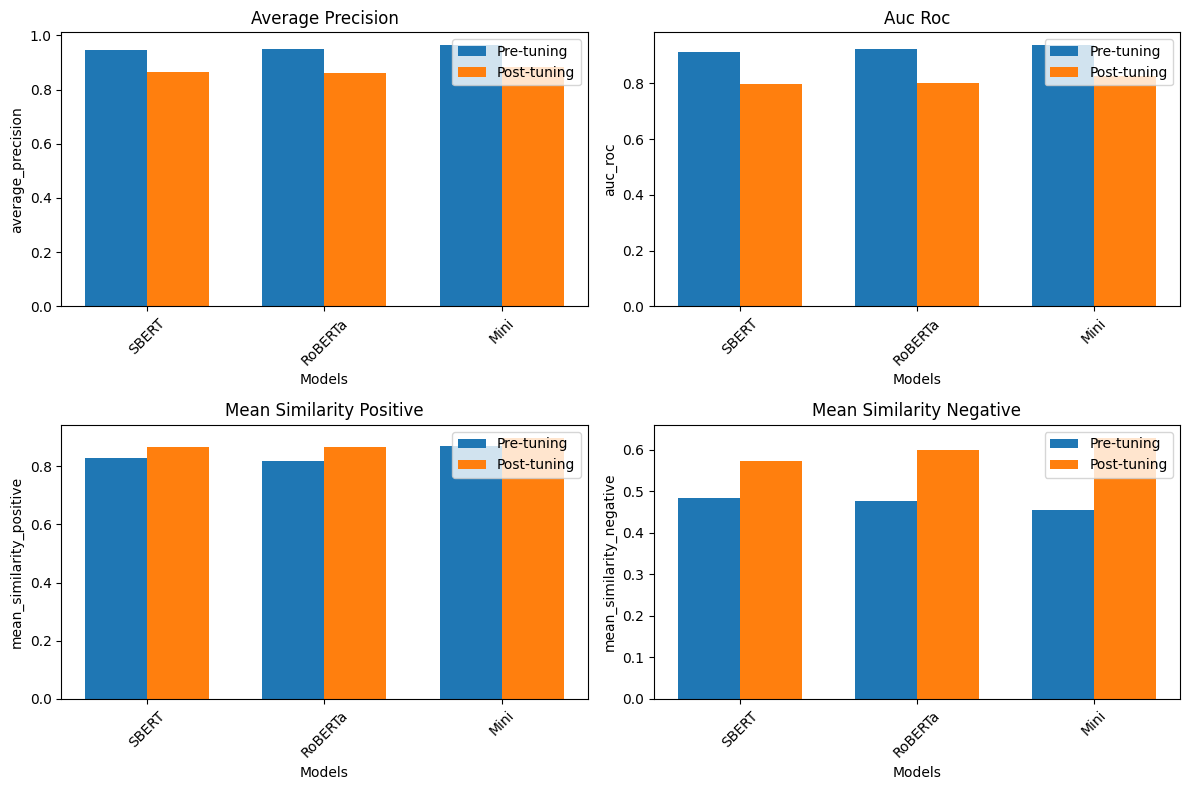

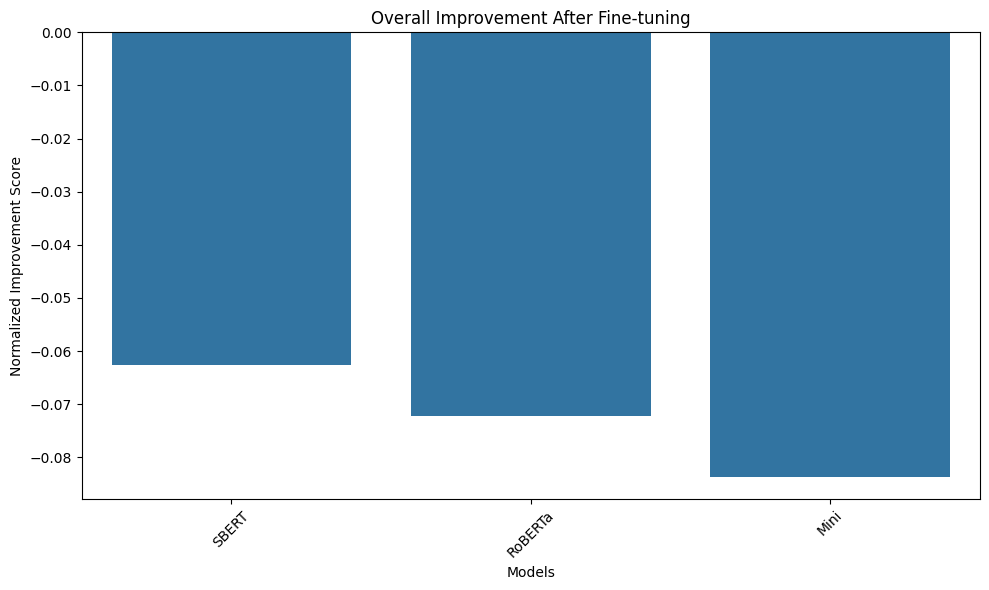

In [60]:
# Calculate overall improvement score
for model_name in results:
    ap_improvement = results[model_name]['improvement']['average_precision']
    auc_improvement = results[model_name]['improvement']['auc_roc']
    pos_sim_improvement = results[model_name]['improvement']['mean_similarity_positive']
    neg_sim_improvement = -results[model_name]['improvement']['mean_similarity_negative']  # We want this to decrease
    
    # Normalized improvement score
    results[model_name]['overall_improvement'] = (
        ap_improvement + auc_improvement + pos_sim_improvement + neg_sim_improvement
    ) / 4

# Sort models by overall improvement
sorted_models = sorted(results.items(), key=lambda x: x[1]['overall_improvement'], reverse=True)

# Visualization
plt.figure(figsize=(12, 8))
metrics = ['average_precision', 'auc_roc', 'mean_similarity_positive', 'mean_similarity_negative']
x = np.arange(len(models))
width = 0.35

for i, metric in enumerate(metrics):
    pre_values = [results[model]['pre_tuning'][metric] for model in models]
    post_values = [results[model]['post_tuning'][metric] for model in models]
    
    plt.subplot(2, 2, i+1)
    plt.bar(x - width/2, pre_values, width, label='Pre-tuning')
    plt.bar(x + width/2, post_values, width, label='Post-tuning')
    plt.xlabel('Models')
    plt.ylabel(metric)
    plt.title(f'{metric.replace("_", " ").title()}')
    plt.xticks(x, models.keys(), rotation=45)
    plt.legend()

plt.tight_layout()
plt.savefig('model_comparison.png')

# Overall improvement visualization
improvement_scores = [results[model]['overall_improvement'] for model in models]

plt.figure(figsize=(10, 6))
sns.barplot(x=list(models.keys()), y=improvement_scores)
plt.title('Overall Improvement After Fine-tuning')
plt.xlabel('Models')
plt.ylabel('Normalized Improvement Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('overall_improvement.png')




In [64]:
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer
import numpy as np
import Levenshtein
from nltk.util import ngrams

# Ensure we're using CPU
device = torch.device('cpu')

# Your provided dataset
businessNames1 = ["HANAN ATHER TRUCKING"]
businessNames2 = [
    "HANAN TAHER TRUCKING",
    "TRUCKING INC HANAN ATHER",
    "ATHER TRUCKING INC",
    "GODBOUT TRUCKING INC",
    "HANAN ATHER PHARMACY INC",
    "Ather INC"
]

def evaluate_model_on_dataset(model, names1, names2):
    with torch.no_grad():
        embeddings1 = model.encode(names1, convert_to_tensor=True, device=device)
        embeddings2 = model.encode(names2, convert_to_tensor=True, device=device)
    
    similarities = torch.nn.functional.cosine_similarity(embeddings1, embeddings2).cpu().numpy()
    
    return similarities

def levenshtein_distance(str1, str2):
    distance = Levenshtein.distance(str1.lower(), str2.lower())
    max_len = max(len(str1), len(str2))
    return 1 - (distance / max_len)

def n_gram_similarity(str1, str2, n=3):
    str1_ngrams = set(ngrams(str1.lower(), n))
    str2_ngrams = set(ngrams(str2.lower(), n))
    return len(str1_ngrams & str2_ngrams) / float(len(str1_ngrams | str2_ngrams))

def jaro_winkler_similarity(str1, str2):
    return Levenshtein.jaro_winkler(str1.lower(), str2.lower())

models = {
    'SBERT': 'all-mpnet-base-v2',
    'RoBERTa': 'all-distilroberta-v1',
    'Mini': 'all-MiniLM-L6-v2',
}

results = []

for i, name2 in enumerate(businessNames2):
    result = {
        'Business Name 1': businessNames1[0],
        'Business Name 2': name2,
        'Levenshtein': levenshtein_distance(businessNames1[0], name2),
        'N-gram': n_gram_similarity(businessNames1[0], name2),
        'Jaro-Winkler': jaro_winkler_similarity(businessNames1[0], name2)
    }
    
    for model_name, model_path in models.items():
        model = SentenceTransformer(model_path, device=device)
        similarities = evaluate_model_on_dataset(model, businessNames1, [name2])
        result[f'{model_name}_Pre-fine-tuned'] = similarities[0]
    
    results.append(result)

# Create DataFrame
df_results = pd.DataFrame(results)

# Reorder columns
columns = ['Business Name 1', 'Business Name 2', 'Levenshtein', 'N-gram', 'Jaro-Winkler']
columns.extend([f'{model}_Pre-fine-tuned' for model in models])

df_results = df_results[columns]

df_results

# Optionally, save to CSV
df_results.to_csv('business_name_similarities.csv', index=False)

        Business Name 1           Business Name 2  Levenshtein    N-gram  \
0  HANAN ATHER TRUCKING      HANAN TAHER TRUCKING     0.900000  0.636364   
1  HANAN ATHER TRUCKING  TRUCKING INC HANAN ATHER     0.083333  0.600000   
2  HANAN ATHER TRUCKING        ATHER TRUCKING INC     0.500000  0.545455   
3  HANAN ATHER TRUCKING      GODBOUT TRUCKING INC     0.300000  0.241379   
4  HANAN ATHER TRUCKING  HANAN ATHER PHARMACY INC     0.666667  0.333333   
5  HANAN ATHER TRUCKING                 Ather INC     0.400000  0.190476   

   Jaro-Winkler  SBERT_Pre-fine-tuned  RoBERTa_Pre-fine-tuned  \
0      0.990000              0.911981                0.913551   
1      0.618254              0.930841                0.876942   
2      0.729630              0.725133                0.701722   
3      0.548485              0.587563                0.523199   
4      0.893333              0.590314                0.497729   
5      0.637963              0.483883                0.419634   

   Mini_Pre

In [65]:
df_results

,Business Name 1,Business Name 2,Levenshtein,N-gram,Jaro-Winkler,SBERT_Pre-fine-tuned,RoBERTa_Pre-fine-tuned,Mini_Pre-fine-tuned
0,HANAN ATHER TRUCKING,HANAN TAHER TRUCKING,0.900000,0.636364,0.990000,0.911981,0.913551,0.929135
1,HANAN ATHER TRUCKING,TRUCKING INC HANAN ATHER,0.083333,0.600000,0.618254,0.930841,0.876942,0.875216
2,HANAN ATHER TRUCKING,ATHER TRUCKING INC,0.500000,0.545455,0.729630,0.725133,0.701722,0.642829
3,HANAN ATHER TRUCKING,GODBOUT TRUCKING INC,0.300000,0.241379,0.548485,0.587563,0.523199,0.465248
4,HANAN ATHER TRUCKING,HANAN ATHER PHARMACY INC,0.666667,0.333333,0.893333,0.590314,0.497729,0.561207
5,HANAN ATHER TRUCKING,Ather INC,0.400000,0.190476,0.637963,0.483883,0.419634,0.357233
